In [1]:
# The MIT License (MIT) Copyright (c) 2023 Emilio Morales
#
# Permission is hereby granted, free of charge, to any person obtaining a copy of
# this software and associated documentation files (the "Software"), to deal in the Software without
# restriction, including without limitation the rights to use, copy, modify, merge, publish,
# distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in all copies or
# substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED,
# INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND
# NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES
# OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN
# CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/milmor/NLP/blob/main/Notebooks/13_RNN_LSTM.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
</table>

# Redes neuronales recurrentes
  
- Dataset: https://www.kaggle.com/datasets/andrewmvd/cyberbullying-classification

In [2]:
import torch
import pandas as pd

torch.__version__

'2.2.1+cu121'

In [3]:
torch.manual_seed(77)

## 1.- Conjuntos de entrenamiento y validación

In [4]:
df = pd.read_csv('./cyberbullying_tweets.csv')

In [5]:
df.head()

,tweet_text,cyberbullying_type
0,"In other words #katandandre, your food was cra...",not_cyberbullying
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying


In [6]:
df['cyberbullying_type'].unique()

array(['not_cyberbullying', 'gender', 'religion', 'other_cyberbullying',
       'age', 'ethnicity'], dtype=object)

In [7]:
# Contar elementos por clase
count = df['cyberbullying_type'].value_counts()
count

cyberbullying_type
religion               7998
age                    7992
gender                 7973
ethnicity              7961
not_cyberbullying      7945
other_cyberbullying    7823
Name: count, dtype: int64

In [8]:
# Creamos un diccionario que mapea cada etiqueta a un número entero
labels_dict = {
    'not_cyberbullying': 0,
    'gender': 1,
    'religion': 2,
    'other_cyberbullying': 3,
    'age': 4,
    'ethnicity': 5
}

df['cyberbullying_type'] = df['cyberbullying_type'].map(labels_dict)
df.head()

,tweet_text,cyberbullying_type
0,"In other words #katandandre, your food was cra...",0
1,Why is #aussietv so white? #MKR #theblock #ImA...,0
2,@XochitlSuckkks a classy whore? Or more red ve...,0
3,"@Jason_Gio meh. :P thanks for the heads up, b...",0
4,@RudhoeEnglish This is an ISIS account pretend...,0


- Elimina puntuación y convierte a minúsculas
- Se utiliza el método __str.translate()__ para eliminar todos los caracteres de puntuación mediante una tabla de traducción creada con el método __str.maketrans__. La constante string.punctuation contiene todos los caracteres de puntuación ASCII, que se eliminan de los valores en la columna

In [9]:
import string
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [10]:
df['tweet_text'] = df['tweet_text'].str.lower().str.translate(str.maketrans('', '', string.punctuation))
df.head()

,tweet_text,cyberbullying_type
0,in other words katandandre your food was crapi...,0
1,why is aussietv so white mkr theblock imaceleb...,0
2,xochitlsuckkks a classy whore or more red velv...,0
3,jasongio meh p thanks for the heads up but no...,0
4,rudhoeenglish this is an isis account pretendi...,0


In [11]:
from sklearn.model_selection import train_test_split
train_df, val_df= train_test_split(df, test_size = 0.15, random_state = 123)

In [12]:
train_df['cyberbullying_type'].value_counts()

cyberbullying_type
0    6826
1    6821
5    6777
4    6763
2    6743
3    6608
Name: count, dtype: int64

## 2.- Pipeline

- Crea vocabulario y define tokenizer.

In [13]:
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import vocab as Vocab
from collections import Counter

In [14]:
tokenizer = get_tokenizer('basic_english')

In [15]:
def build_vocab(text, tokenizer, min_freq=5):
    counter = Counter()
    for string_ in text:
        counter.update(tokenizer(string_))
    return Vocab(counter, min_freq=min_freq,
                 specials=['<unk>', '<pad>'])


vocab = build_vocab(train_df.tweet_text.values, tokenizer, 5)

In [16]:
vocab_size = len(vocab) + 1
vocab_size

9952

In [17]:
vocab.set_default_index(len(vocab)) # evita error <ukn>

In [18]:
maxlen = 64

def data_process(x, y):
    data = []
    for raw_txt, target in zip(x, y):
        tensor_ = torch.tensor([vocab[token] for token in tokenizer(raw_txt)],
                        dtype=torch.long)
        if tensor_.shape[0] <= maxlen:
            # int64 to avoid CrossEntropyLoss "expected scalar type Long but found Float"
            target_ = torch.tensor(target, dtype=torch.int64)
            data.append((tensor_, target_))
    return data

train_data = data_process(train_df.tweet_text.values,
                          train_df.cyberbullying_type.values)
val_data = data_process(val_df.tweet_text.values,
                        val_df.cyberbullying_type.values)
len(train_data), len(val_data)

(40523, 7149)

In [19]:
batch_size = 64
PAD_IDX = vocab['<pad>']

from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader

def generate_batch(data_batch):
    x, y = [], []
    for (x_item, y_item) in data_batch:
        x.append(x_item)
        y.append(y_item)

    x = pad_sequence(x, batch_first=True, padding_value=PAD_IDX)
    # int64 to avoid CrossEntropyLoss "expected scalar type Long but found Float"
    y = torch.tensor(y, dtype=torch.int64)
    return x, y


train_loader = DataLoader(train_data, batch_size=batch_size,
                          shuffle=True, collate_fn=generate_batch,
                          num_workers=4, pin_memory=True)
val_loader = DataLoader(val_data, batch_size=batch_size,
                        shuffle=True, collate_fn=generate_batch,
                        num_workers=4, pin_memory=True)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [20]:
%%timeit
train_batch, target_batch = next(iter(train_loader))

955 ms ± 38.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [21]:
train_batch, target_batch = next(iter(train_loader))

In [22]:
train_batch.shape, target_batch.shape

(torch.Size([64, 63]), torch.Size([64]))

## 3.- Modelo

### RNN simple

RNN:
\begin{equation}
h_t = f(Wx_t + Uh_{t-1} + b)
\end{equation}

In [23]:
import torch.nn as nn
from torch import optim
import time

In [24]:
class Attention(nn.Module):
    def __init__(self, dim, h):
        super(Attention, self).__init__()
        self.dim = dim
        self.h = h
        self.h_dim = int(dim/h)
        self.scale = self.h_dim ** -0.5
        self.wq = nn.Linear(dim, dim)
        self.wk = nn.Linear(dim, dim)
        self.wv = nn.Linear(dim, dim)

    def forward(self, x):
      B, L, D = x.shape
      q = self.wq(x)
      k = self.wk(x)
      v = self.wv(x)
      q = q.reshape([B, L, self.h_dim, -1])
      q = q.permute([0, 3, 1, 2])
      k = k.reshape([B, L, self.h_dim, -1])
      k = k.permute([0, 3, 2, 1])
      v = v.reshape([B, L, self.h_dim, -1])
      v = v.permute([0, 3, 1, 2])

      qk = torch.matmul(q, k)
      attn = torch.softmax(qk / self.scale, -1)
      out = torch.matmul(attn, v).permute([0, 2, 1, 3])
      out = out.reshape([B, L, -1])
      return out

b = torch.ones([2, 256, 16])
a= Attention(16, 2)
a(b).shape

torch.Size([2, 256, 16])

In [25]:
class TransformerBlock(nn.Module):
    def __init__(self, dim, h):
        super(TransformerBlock, self).__init__()
        self.ln1 = torch.nn.LayerNorm(dim)
        self.ln2 = torch.nn.LayerNorm(dim)
        self.attn = Attention(dim, h)
        self.mlp = torch.nn.Sequential(
            nn.Linear(dim, dim),
            nn.GELU(),
            nn.Linear(dim, dim)
        )

    def forward(self, inp):
      x = self.attn(inp) + inp
      skip = self.ln1(x)
      x = self.mlp(skip) + skip
      x = self.ln2(x)
      return x

t=TransformerBlock(16, 2)
t(b)

tensor([[[ 0.0147,  1.0894, -1.5585,  ...,  2.7538, -0.4757, -0.7635],
         [ 0.0147,  1.0894, -1.5585,  ...,  2.7538, -0.4757, -0.7635],
         [ 0.0147,  1.0894, -1.5585,  ...,  2.7538, -0.4757, -0.7635],
         ...,
         [ 0.0147,  1.0894, -1.5585,  ...,  2.7538, -0.4757, -0.7635],
         [ 0.0147,  1.0894, -1.5585,  ...,  2.7538, -0.4757, -0.7635],
         [ 0.0147,  1.0894, -1.5585,  ...,  2.7538, -0.4757, -0.7635]],

        [[ 0.0147,  1.0894, -1.5585,  ...,  2.7538, -0.4757, -0.7635],
         [ 0.0147,  1.0894, -1.5585,  ...,  2.7538, -0.4757, -0.7635],
         [ 0.0147,  1.0894, -1.5585,  ...,  2.7538, -0.4757, -0.7635],
         ...,
         [ 0.0147,  1.0894, -1.5585,  ...,  2.7538, -0.4757, -0.7635],
         [ 0.0147,  1.0894, -1.5585,  ...,  2.7538, -0.4757, -0.7635],
         [ 0.0147,  1.0894, -1.5585,  ...,  2.7538, -0.4757, -0.7635]]],
       grad_fn=<NativeLayerNormBackward0>)

In [26]:
class Transformer(nn.Module):
    def __init__(self, vocab_size, maxlen, dim, h):
        super(Transformer, self).__init__()
        self.dim = dim
        self.emb = nn.Embedding(vocab_size, dim)
        self.pos = nn.Parameter(torch.rand(1, maxlen, dim))

        self.transformer = nn.Sequential()

        for _ in range(4):
            self.transformer.append(
                TransformerBlock(dim, h)
            )

        self.mlp_head=torch.nn.Sequential(
            torch.nn.LayerNorm(dim),
            nn.Linear(dim, 6)
        )

    def forward(self, x):
        B, L = x.shape
        x = self.emb(x) + self.pos[:, L, :]
        x = self.transformer(x)
        x = self.mlp_head(x[:,  -1, :])
        return x

trans =Transformer(9952, 64+1, 64, 2)
trans(train_batch).shape

torch.Size([64, 6])

In [27]:
class RNN(nn.Module):
    def __init__(self, vocab_size):
        super(RNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, 128)
        self.rnn = nn.RNN(input_size=128,
                        hidden_size=128,
                        num_layers=1,
                        batch_first=True)
        self.fc1 = nn.Linear(128, 16)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(16, 16)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(16, 6)

    def forward(self, x):
        x = self.embedding(x)
        x, hidden = self.rnn(x)
        x = x[:, -1, :]
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        return x

rnn = RNN(vocab_size)
output_batch = rnn(train_batch)
output_batch.shape

torch.Size([64, 6])

### LSTM

LSTM:

\begin{align}
i_t & = \sigma(W^ix_t + U^ih_{t-1} + b^i) \\
f_t & = \sigma(W^fx_t + U^fh_{t-1} + b^f) \\
o_t & = \sigma(W^ox_t + U^oh_{t-1} + b^o) \\
g_t & = \text{tanh}(W^gx_t + U^gh_{t-1} + b^g) \\
c_t & = f_t \odot c_{t-1} + i_t \odot g_t\\
h_t & = o_t \odot \text{tanh}(c_t) \\
\end{align}

In [28]:
class LSTM(nn.Module):
    def __init__(self, vocab_size):
        super(LSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, 128)
        self.lstm = nn.LSTM(input_size=128,
                        hidden_size=128,
                        num_layers=1,
                        batch_first=True)
        self.fc1 = nn.Linear(128, 16)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(16, 16)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(16, 6)

    def forward(self, x):
        x = self.embedding(x)
        x, (hidden, cell) = self.lstm(x)
        x = x[:, -1, :]
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        return x

lstm = LSTM(vocab_size)
output_batch = lstm(train_batch)
output_batch.shape

torch.Size([64, 6])

## 4.- Entrenamiento

In [29]:
loss_fn = torch.nn.CrossEntropyLoss()

In [30]:
def train(model, device, train_loader, optimizer, epoch):
    start = time.time()
    running_loss = 0.0
    model.train()
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        outputs = outputs.squeeze()
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f'\nTime for epoch {epoch} is {time.time()-start:.4f} sec Train loss: {running_loss / len(train_loader):.4f}')

In [31]:
def test(model, device, test_loader):
    start = time.time()
    running_loss = 0.0
    running_acc = 0.0
    with torch.no_grad():
        model.eval()
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            outputs = outputs.squeeze()
            loss = loss_fn(outputs, labels)
            _, pred = torch.max(outputs.data, 1)
            running_acc += (pred == labels).sum().item()
            running_loss += loss.item()

    print(f'Time for eval is {time.time()-start:.4f} sec Val loss: {running_loss / len(test_loader):.4f}')
    print(f'Val acc: {running_acc / len(test_loader.dataset):.4f}')

In [32]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [33]:
trans.to(device)

trans_optimizer = optim.Adam(trans.parameters(), lr=0.001)

In [34]:
epochs = 7

for epoch in range(epochs):
    train(trans, device, train_loader, trans_optimizer, epoch)
    test(trans, device, val_loader)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



Time for epoch 0 is 8.6568 sec Train loss: 0.9659
Time for eval is 0.7652 sec Val loss: 0.7133
Val acc: 0.7061

Time for epoch 1 is 8.2849 sec Train loss: 0.6809
Time for eval is 0.7083 sec Val loss: 0.6405
Val acc: 0.7372

Time for epoch 2 is 12.7183 sec Train loss: 0.6115
Time for eval is 1.0410 sec Val loss: 0.5921
Val acc: 0.7545

Time for epoch 3 is 10.7821 sec Train loss: 0.5975
Time for eval is 0.7138 sec Val loss: 0.5610
Val acc: 0.7733

Time for epoch 4 is 7.9813 sec Train loss: 0.5564
Time for eval is 0.6846 sec Val loss: 0.5492
Val acc: 0.7682

Time for epoch 5 is 7.4834 sec Train loss: 0.5437
Time for eval is 0.9057 sec Val loss: 0.5302
Val acc: 0.7773

Time for epoch 6 is 7.7129 sec Train loss: 0.5455
Time for eval is 0.6910 sec Val loss: 0.5171
Val acc: 0.7882


In [35]:
lstm.to(device)

lstm_optimizer = optim.Adam(lstm.parameters(), lr=0.001)

In [36]:
epochs = 7

for epoch in range(epochs):
    train(lstm, device, train_loader, lstm_optimizer, epoch)
    test(lstm, device, val_loader)


Time for epoch 0 is 3.5159 sec Train loss: 1.3680
Time for eval is 0.6819 sec Val loss: 0.6391
Val acc: 0.7327

Time for epoch 1 is 3.2970 sec Train loss: 0.5137
Time for eval is 0.4472 sec Val loss: 0.4614
Val acc: 0.8000

Time for epoch 2 is 2.9945 sec Train loss: 0.4201
Time for eval is 0.4639 sec Val loss: 0.4316
Val acc: 0.8205

Time for epoch 3 is 3.0675 sec Train loss: 0.3666
Time for eval is 0.4816 sec Val loss: 0.4322
Val acc: 0.8163

Time for epoch 4 is 3.7423 sec Train loss: 0.3185
Time for eval is 0.4601 sec Val loss: 0.4324
Val acc: 0.8194

Time for epoch 5 is 2.9889 sec Train loss: 0.2748
Time for eval is 0.4468 sec Val loss: 0.4382
Val acc: 0.8265

Time for epoch 6 is 3.0002 sec Train loss: 0.2364
Time for eval is 0.4557 sec Val loss: 0.4921
Val acc: 0.8183


## 5.- Vectores

In [37]:
words = 'bad good hate happy love scared friend sad alive family confident fight live funny best great amazing'
words_ids = torch.tensor([vocab[token] for token in tokenizer(words)])
words_ids

tensor([ 588,  248,  493, 1192,  820, 3232,  731, 1844,  788,  593, 5176,  749,
        1171,  269,  604, 1692, 2801])

In [38]:
lstm.to('cpu')
lstm.eval()

LSTM(
  (embedding): Embedding(9952, 128)
  (lstm): LSTM(128, 128, batch_first=True)
  (fc1): Linear(in_features=128, out_features=16, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=16, out_features=16, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=16, out_features=6, bias=True)
)

In [39]:
embeddings = lstm.embedding(words_ids).detach()
embeddings.shape

torch.Size([17, 128])

- Visualización de los vectores aprendidos

(17, 2)


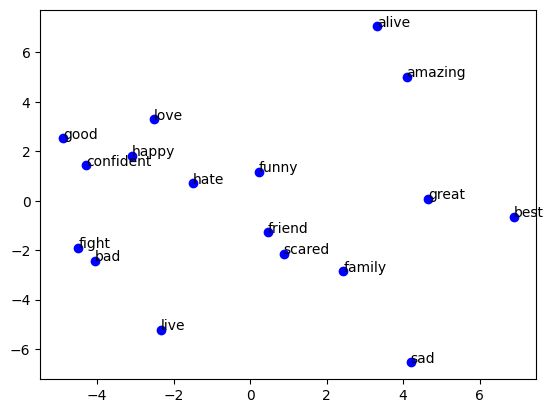

In [40]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA


# Perform PCA on embeddings
pca = PCA(n_components=2)
pca_embeddings = pca.fit_transform(embeddings)
print(pca_embeddings.shape)

# Plot embeddings using matplotlib
fig, ax = plt.subplots()
ax.scatter(pca_embeddings[:, 0], pca_embeddings[:, 1], marker='o', c='b')

for i, word in enumerate(words.split()):
    ax.annotate(word, (pca_embeddings[i, 0], pca_embeddings[i, 1]))

plt.show()

## 6.- Conclusiones

En este ejercicio se implementó un modelo Transformer con una capa de atención y una capa feedforward con conexiones residuales y normalización.

En la capa de atención, como se vió en teoría, se realizan transformaciones para generar tres matrices q, k y v. Estas matrices, claves y valores se dividen en múltiples headers. Al final se aplica una función softmax para obtener los pesos de atención normalizados.

La capa TransformerBlock encapsula la unidad básica del Transformer y consiste de una capa de atención seguida de una capa feedforward (MLP). Después de la capa de atención se añade una conexión residual y se normaliza la salida con una capa de normalización, este proceso también ocurre después del MLP.

Finalmente la clase Transformer consiste en una capa de embedding seguida de una suma con embeddings de posición y multiples bloques de transformers en secuencia donde al final se normalizan los valores y se utiliza una capa lineal para la clasificación.